In [1]:
import sys, os
print("Kernel Python:", sys.executable)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
print("PyTorch:", torch.__version__)
print(torch.version.cuda)   # shows the CUDA version PyTorch was built against
print(torch.backends.cudnn.version())  # cuDNN version
print(torch.cuda.is_available())

from tqdm import tqdm
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig

Kernel Python: /work3/s232958/envs/esm3/bin/python
PyTorch: 2.9.1+cu128
12.8
91002
False
Using device: cpu
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


/work3/s232958/envs/esm3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load metaanalayis data
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/source_data.csv")
interaction_df = interaction_df[(interaction_df["A_seq"].notna())& (interaction_df["B_seq"].notna())].reset_index(drop=True)
interaction_df = interaction_df[interaction_df["target_chains"] == "[\"B\"]"]
interaction_df = interaction_df[interaction_df["B_seq"].notna()].reset_index(drop=True)
cols_remain = ["binder_id", "target_id", "binder_chain", "target_chains", "binder", "A_seq", "B_seq"]
interaction_df = interaction_df[cols_remain]
# interaction_df = interaction_df.drop(columns=["binder_chain", "target_chains"])

interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...
...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...


In [3]:
# No NaN target_id rows
print(f"{len(interaction_df[interaction_df.target_id.isna() == True])} entries with 'target_id' nan")
interaction_df[interaction_df.target_id.isna() == True]

x = interaction_df["target_id"].unique()
print(f"{len(x)} different targets, which are: {x}")

x = interaction_df[interaction_df["target_id"] == "EGFR"]["B_seq"].unique()
print(f"Target 'EGFR' has {len(x)} unique sequences.")

0 entries with 'target_id' nan
13 different targets, which are: ['VirB8' 'FGFR2' 'IL7Ra' 'InsulinR' 'EGFR' 'SARS_CoV2_RBD' 'Pdl1' 'TrkA'
 'IL10Ra' 'LTK' 'Mdm2' 'sntx' 'IL2Ra']
Target 'EGFR' has 3 unique sequences.


In [4]:
print(f"Tagets and number of diff sequences for each:")
for i in interaction_df["target_id"].unique():
    x = interaction_df[interaction_df["target_id"] == i]["B_seq"].unique()
    print(i, len(x))

Tagets and number of diff sequences for each:
VirB8 1
FGFR2 1
IL7Ra 1
InsulinR 1
EGFR 3
SARS_CoV2_RBD 1
Pdl1 1
TrkA 1
IL10Ra 1
LTK 1
Mdm2 1
sntx 2
IL2Ra 1


In [5]:
dfu = interaction_df.drop_duplicates(["target_id", "B_seq"])
dfu[dfu.target_id == "EGFR"].B_seq.tolist()
targets_Dict, target_tracking = {}, {target:int(2) for target in dfu.target_id.unique()}
target_tracking

{'VirB8': 2,
 'FGFR2': 2,
 'IL7Ra': 2,
 'InsulinR': 2,
 'EGFR': 2,
 'SARS_CoV2_RBD': 2,
 'Pdl1': 2,
 'TrkA': 2,
 'IL10Ra': 2,
 'LTK': 2,
 'Mdm2': 2,
 'sntx': 2,
 'IL2Ra': 2}

In [6]:
for idx, target_id in enumerate(dfu.target_id):
    if target_id not in targets_Dict.keys():
        targets_Dict[target_id] = dfu.iloc[idx]["B_seq"]
        print(target_id)
    else:
        target_id_new = f"{target_id}_{target_tracking[target_id]}"
        targets_Dict[target_id_new] = dfu.iloc[idx]["B_seq"]
        count = target_tracking[target_id]
        target_tracking[target_id] = count + 1
        print(target_id_new)

VirB8
FGFR2
IL7Ra
InsulinR
EGFR
SARS_CoV2_RBD
Pdl1
EGFR_2
TrkA
IL10Ra
LTK
Mdm2
EGFR_3
sntx
sntx_2
IL2Ra


In [7]:
interaction_df['target_id_mod'] = interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
interaction_df['B_seq'].map({b:a for a, b in targets_Dict.items()})
print(targets_Dict.keys())
print(f"Entries wheere 'target_id_mod' is NA: {len(interaction_df[interaction_df.target_id_mod.isna() == True])}")

dict_keys(['VirB8', 'FGFR2', 'IL7Ra', 'InsulinR', 'EGFR', 'SARS_CoV2_RBD', 'Pdl1', 'EGFR_2', 'TrkA', 'IL10Ra', 'LTK', 'Mdm2', 'EGFR_3', 'sntx', 'sntx_2', 'IL2Ra'])
Entries wheere 'target_id_mod' is NA: 0


In [8]:
interaction_df[interaction_df.target_id_mod == "EGFR_3"]

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod
1130,nside_mot_359448c81ec7171dd466f2d64631b9c5_000...,EGFR,A,"[""B""]",True,DDESLKLLLILVQIQLALERGEISNDQAKELAKRVEEKARKLGDEQ...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
1516,nside_mot_4a0b58da0a66d934d1bcaa80596e03bc_000...,EGFR,A,"[""B""]",True,DHWEEVFRWALELLQEATEQNDPTKAKKILEEAHKLLRRELSEEEA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2268,nside_mot_33a3a00fc629d06a96f91cefd1c5e1ea_000...,EGFR,A,"[""B""]",True,PLEEVKKVVEEALKDDPELVRAVKTIIEAVKKGENDPIFLELLLRL...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3
2634,nside_mot_4baece34555bc5def11fd3c4c5db93f5_000...,EGFR,A,"[""B""]",True,DEAAEEVLRYLKKLGDPELAELIERLLERVRKKKDPDLERTLEIIA...,VCQGTSNKLTQLGTFEDHFLSLQRMFNNCEVVLGNLEITYVQRNYD...,EGFR_3


In [9]:
cnt = interaction_df.groupby('target_id_mod').cumcount() + 1
interaction_df['target_binder_ID'] = interaction_df['target_id_mod'].astype(str) + '_' + cnt.astype(str)
interaction_df

,binder_id,target_id,binder_chain,target_chains,binder,A_seq,B_seq,target_id_mod,target_binder_ID
0,EHEE_rd4_0110_min_rise1_21_000000015_0001,VirB8,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1
1,Grafting_Motif0040_ems_3hM_3083_0001_0002,FGFR2,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1
2,Grafting_Motif0042_ems_3hM_148_0001,FGFR2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2
3,Grafting_Motif0042_ems_3hM_1661_0001,FGFR2,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3
4,Grafting_Motif0042_ems_3hM_257_0001,FGFR2,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4
...,...,...,...,...,...,...,...,...,...
3527,il2ra_site1_2b5i_sap_19_mot_HHH_b2_06055_af2_0...,IL2Ra,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62
3528,il2ra_site1_2b5i_sap_20_mot_HHH_b1_01934_af2_0...,IL2Ra,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63
3529,il2ra_site1_2b5i_sap_23_mot_88fc943612ced423dc...,IL2Ra,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64
3530,il2ra_site1_2b5i_sap_25_mot_HHH_b2_01943_00000...,IL2Ra,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65


In [10]:
interaction_df.binder.value_counts()

binder
False    3141
True      391
Name: count, dtype: int64

In [11]:
len(interaction_df.target_id_mod.unique())

16

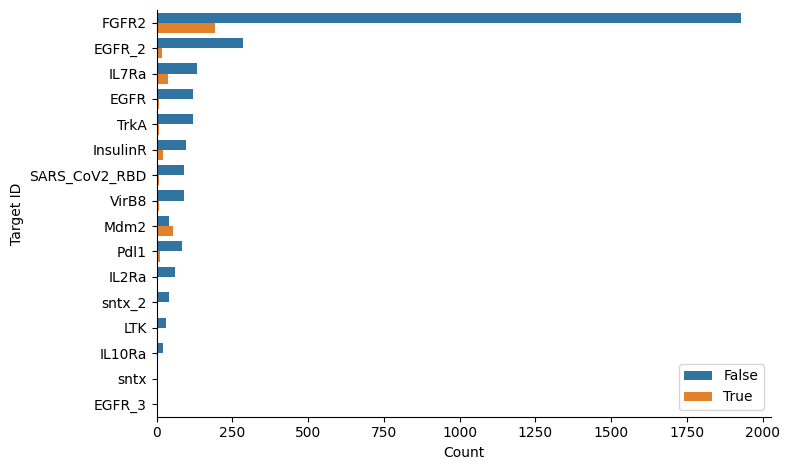

In [12]:
interaction_df.target_id_mod.value_counts()

order = interaction_df['target_id_mod'].value_counts().index

plt.figure(figsize=(8, 0.3 * len(order)))
ax = sns.countplot(
    data=interaction_df,
    y='target_id_mod',
    order=order,
    hue = "binder"
)
ax.set_xlabel('Count')
ax.set_ylabel('Target ID')
ax.legend(loc='lower right')  
sns.despine()
plt.tight_layout()
plt.show()

In [15]:
interaction_dict_B, interaction_dict_T= {}, {}

for _, row in interaction_df.iterrows():
    binder_key = row.target_binder_ID
    binder_seq = row.A_seq
    target_key = row.target_id_mod
    target_seq = row.B_seq

    # Insert binder
    interaction_dict_B[binder_key] = binder_seq

    # Insert target only once
    if target_key not in interaction_dict_T:
        interaction_dict_T[target_key] = target_seq
        # print(target_key, target_seq)
interaction_dict_T

{'VirB8': 'ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQFANFMNIDNSLSPVIRYQKLYRRSINIISINNINNNEATVTFESLAQNNTGEILENMLWEAKIGFIMDSISTNMPFHFIVTSYKLKLLRNKNQ',
 'FGFR2': 'RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPYLKVLKAAGVNTTDKEIEVLYIRNVTFEDAGEYTCLAGNSIGISFHSAWLTVLPAP',
 'IL7Ra': 'DYSFSCYSQLEVNGSQHSLTCAFEDPDVNTTNLEFEICGALVEVKCLNFRKLQEIYFIETKKFLLIGKSNICVKVGEKSLTCKKIDLTTIVKPEAPFDLSVVYREGANDFVVTFNTSHLQKKYVKVLMHDVAYRQEKDENKWTHVNLSSTKLTLLQRKLQPAAMYEIKVRSIPDHYFKGFWSEWSPSYYFRTP',
 'InsulinR': 'EVCPGMDIRNNLTRLHELENCSVIEGHLQILLMFKTRPEDFRDLSFPKLIMITDYLLLFRVYGLESLKDLFPNLTVIRGSRLFFNYALVIFEMVHLKELGLYNLMNITRGSVRIEKNNELCYLATIDWSRILDSVEDNHIVLNKDDNEEC',
 'EGFR': 'RKVCNGIGIGEFKDSLSINATNIKHFKNCTSISGDLHILPVAFRGDSFTHTPPLDPQELDILKTVKEITGFLLIQAWPENRTDLHAFENLEIIRGRTKQHGQFSLAVVSLNITSLGLRSLKEISDGDVIISGNKNLCYANTINWKKLFGTSGQKTKIISNRGENSCKATGQVCHALCSPEGCWGPEPRDCV',
 'SARS_CoV2_RBD': 'TNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDI

In [16]:
# Save modified interaction_df
interaction_df.to_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv", index = False)

In [15]:
### ESM-C embeddings calculated running cal_esmC.py

# client = ESMC.from_pretrained("esmc_600m", device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# def calculate_ESM_pr_res_embeddings(sequence):
#     protein = ESMProtein(sequence=sequence)
#     protein_tensor = client.encode(protein)
#     logits_output = client.logits(
#     protein_tensor, LogitsConfig(sequence=True, return_embeddings=True)
#     )
#     return logits_output.embeddings.detach().cpu().numpy()

# path_to_output_embeddings = "/work3/s232958/data/meta_analysis/embeddings_esmC"
# os.makedirs(path_to_output_embeddings, exist_ok=True)

# # helper: convert torch tensor to numpy
# def to_numpy(x):
#     try:
#         return x.detach().cpu().numpy()
#     except AttributeError:
#         return np.asarray(x)
    
# for name, seq in tqdm(binders_targets_Dict.items(), total=len(binders_targets_Dict.items()), desc="Embedding targets"):
#     emb = calculate_ESM_pr_res_embeddings(seq)[0]
#     emb_np = to_numpy(emb)
#     out_path = os.path.join(path_to_output_embeddings, f"{name}.npy")
#     np.save(out_path, emb_np)
#     print(f"Protein {name} embedded and saved to {out_path}")

In [18]:
sample = os.listdir("/work3/s232958/data/meta_analysis/embeddings_esmC")[0]
path_to_output_embeddings = "/work3/s232958/data/meta_analysis/embeddings_esmC"
path_to_output_file = os.path.join(path_to_output_embeddings,f"{sample}")
random_embedding = np.load(path_to_output_file)
print(random_embedding.shape)

(64, 1152)
